# HI Survey

This tutorial goes through the data reduction of position switched observations of the 21 cm HI line. The data used for this tutorial is part of the [New Reference Catalog of Extragalactic HI Observations
](https://greenbankobservatory.org/~koneil/HIsurvey/index.shtml) by [Karen O'Neil](https://greenbankobservatory.org/~koneil/). For more details about how the observations were set up, please refer to the [GBTdocs HI Position Switched (psw) Spectrum tutorial](https://gbtdocs.readthedocs.io/en/latest/tutorials/hi_psw_tutorial.html#) or the [survey article](https://greenbankobservatory.org/~koneil/paps/HIsurvey.html).

Some basic information about the observations. The observations use position switching, and in some cases, the data is recorded without firing a noise diode, so that it is not possible to derive a system temperature from those records alone. In those cases, we will use observations close in time when the noise diodes where fired.

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/hi_survey.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/hi_survey.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
import numpy as np

# This module is used for custom plotting.
import matplotlib.pyplot as plt

# We will use this module to compare with published results.
import pandas as pd

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/hi-survey/data/AGBT04A_008_02.raw.acs/AGBT04A_008_02.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use {py:class}`GBTFITSLoad <dysh.fits.GBTFITSLoad>` to load the data, and then its {py:class}`summary <dysh.fits.GBTFITSLoad.summary>` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

/home/scratch/psalas/python/dysh/py3.10-venv/lib/python3.10/site-packages/pandas/core/groupby/ops.py:1186: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.16.98.76', 57528), raddr=('192.33.116.7', 80)>
  mgr = sdata._mgr.get_slice(slice_obj, axis=1 - self.axis)


In [4]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
220,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,185.2806,82.0246
221,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,187.2136,81.9980
222,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,193.8331,81.8413
223,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,195.6766,81.7788
224,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,195.5182,80.2910
225,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,5,1,199.9358,81.6005
226,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,200.8333,80.0265
227,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,205.9471,81.2609
228,B1328+254,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,207.5257,73.9844
229,B1328+254,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,210.9600,75.1584


There is a total of 81 scans in this data set, all used a single spectral window (IF), two polarizations (PLNUM), and a single feed (FDNUM).

## Data Reduction

### Noise Diode Temperature

The first step in calibrating the data is to determine the temperature of the noise diode(s).
It is a known issue with GBT observations that the values provided are only accurate to $\sim20\%$ (see e.g., [Goddy et al 2020](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4....3G/abstract)).
The data we are working with contains eight scans of 3C286, a known calibrator source (see e.g., [Perley & Butler 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..230....7P/abstract)).
We use the last two (scans 226 and 227), as the other seem to have problems, to derive the temperature of the noise diode(s).

#### Computing the Noise Diode Temperature

To derive the temperature of the noise diode(s) we use the {py:class}`gettcal <dysh.fits.gbtfitsload.GBTFITSLoad.gettcal>` method.
This method is described in more detail in another tutorial.
`gettcal` requires a `zenith_opacity` as input.
Since this an L-band observation, we use a value of 0.08.
The exact value does not have a significant impact on the results.

In [5]:
tcal = sdfits.gettcal(scan=226, ifnum=0, plnum=0, fdnum=0, zenith_opacity=0.08)

The return from `gettcal` is a {py:class}`TCal <dysh.spectra.tcal.TCal>` object, which is a child of {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>`, so it has the same methods and properties, plus a `name` and `snu` (the flux density of the calibrator) properties.
To get the mean value of the noise diode temperature over the inner $80\%$ of the spectral window we use the {py:class}`TCal.get_tcal <dysh.spectra.tcal.TCal.get_tcal>` method.

In [6]:
tcal_0 = tcal.get_tcal()
print(tcal_0)

20.488287


Thus the temperature of the noise diode for polarization 0 is $20.49$ K.
We do the same for the second polarization.

In [7]:
tcal = sdfits.gettcal(scan=226, ifnum=0, plnum=1, fdnum=0, zenith_opacity=0.08)
tcal_1 = tcal.get_tcal()
print(tcal_1)

23.851044


#### Updating the Noise Diode Temperature
It is possible to provide the value of the noise diode temperature using the `t_cal` argument to the calibration methods.
An alternative is to update the metadata of the `GBTFITSLoad` object with the new values.
Here we use the second approach.
First we need to determine where the derived noise temperatures are applicable.
This is important as there are two choices for the noise diode temperature, high or low.
We start by determining what noise diode was use for scan 226, we one we used to derive the noise diode temperature.
We leverage the summary, and its `add_columns` and `scan` arguments.
The type of noise diode used is stored in the "CALTYPE" column of an SDFITS.
We also show the noise diode temperature stored in the metadata, in the "TCAL" column.

In [8]:
sdfits.summary(scan=226, add_columns="CALTYPE, TCAL")

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION,CALTYPE,TCAL
226,3C286,0.0,OffOn,1,1.4,1.4,1,2,6,1,200.8333,80.0265,HIGH,21.317758


So, for scan 226 the "high" noise diode was used, and its value is not that far from what we found earlier.
Where else was it used?

In [9]:
sdfits.summary(add_columns="CALTYPE")

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION,CALTYPE
220,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,185.2806,82.0246,HIGH
221,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,187.2136,81.9980,HIGH
222,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,193.8331,81.8413,HIGH
223,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,195.6766,81.7788,HIGH
224,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,195.5182,80.2910,HIGH
225,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,5,1,199.9358,81.6005,HIGH
226,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,200.8333,80.0265,HIGH
227,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,205.9471,81.2609,HIGH
228,B1328+254,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,207.5257,73.9844,HIGH
229,B1328+254,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,210.9600,75.1584,HIGH


All, but a single scan (which we won't use in this tutorial), used the "high" noise diode.


Now we update all of the rows, with the corresponding noise diode temperature.
We have to update both polarizations separately.
In this example we only have one spectral window and one beam, but if we had more, we would also need to separate those cases, as each beam can have a different noise diode and the temperature of the noise diode is a function of frequency.

To access the metadata, we use the `index` property of the `GBTFITSLoad` object, which is a `pandas.DataFrame` object.
Then we select only those rows where "PLNUM" is equal to the value we are interested in (e.g., `sdfits["PLNUM"] == 0`).

In [10]:
sdfits.index().loc[sdfits["PLNUM"] == 0, "TCAL"] = tcal_0
sdfits.index().loc[sdfits["PLNUM"] == 1, "TCAL"] = tcal_1

Now we show how to double check that the values where updated:

In [11]:
sdfits["TCAL"][ (sdfits["SCAN"] == 226) & (sdfits["PLNUM"] == 0) ], tcal_0

(142    20.488287
 143    20.488287
 146    20.488287
 147    20.488287
 150    20.488287
 151    20.488287
 154    20.488287
 155    20.488287
 158    20.488287
 159    20.488287
 162    20.488287
 163    20.488287
 Name: TCAL, dtype: float32,
 20.488287)

In [12]:
sdfits["TCAL"][ (sdfits["SCAN"] == 226) & (sdfits["PLNUM"] == 1) ], tcal_1

(140    23.851044
 141    23.851044
 144    23.851044
 145    23.851044
 148    23.851044
 149    23.851044
 152    23.851044
 153    23.851044
 156    23.851044
 157    23.851044
 160    23.851044
 161    23.851044
 Name: TCAL, dtype: float32,
 23.851044)

The above shows that the values were successfully updated.

Now we can proceed calibrating the data.

### Single On/Off Pair
We will start by reducing data for a single pair of position switched scans, which used the noise diodes. We will use scan 270. First, we calibrate the data for a single polarization, `plnum=0`. We use the {py:class}`getps <dysh.fits.gbtfitsload.GBTFITSLoad.getps>` method of `GBTFITSLoad`, which returns a {py:class}`ScanBlock <dysh.spectra.scan.ScanBlock>`. Since we are calibrating a single pair of position switched scans, the use of a `ScanBlock` won't be evident, but we will see it when we calibrate multiple pairs of observations.

In [13]:
pssb0 = sdfits.getps(scan=270, plnum=0, ifnum=0, fdnum=0)
pssb0

ScanBlock([<dysh.spectra.scan.PSScan at 0x7fabd00dfeb0>])

The return is a `ScanBlock` with a single {py:class}`PSScan <dysh.spectra.scan.PSScan>` in it. We can extract information from the observations by querying the different attributes of the `PSScan`, like the system temperature in K (`tsys`), or exposure time in seconds (`exposure`).

In [14]:
pssb0[0].tsys

array([25.5281268 , 25.53413116, 25.54545267, 25.51954586, 25.53610295,
       25.54238206, 25.52621493, 25.51971548, 25.50964588, 25.54143205,
       25.54019773, 25.53505961, 25.52427646, 25.53010434, 25.52924467,
       25.52770188, 25.52649021, 25.52654657, 25.5655992 , 25.54277555,
       25.53489685, 25.5230316 , 25.52542424, 25.52569588, 25.53033634,
       25.52895463, 25.52776397, 25.56483491, 25.52837916, 25.52476141])

In [15]:
pssb0[0].exposure

array([4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948797,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948785, 4.77948809,
       4.77948809, 4.77948809, 4.77948809, 4.77948809, 4.77948809,
       4.77948809, 4.77948809, 4.77948797, 4.77948797, 4.77948809])

In [16]:
pssb0[0].scan

271

In [17]:
pssb0[0].plnum

0

In [18]:
pssb0[0].ifnum

0

Notice that the `PSScan` says it has a scan number (`scan`) of 271. This is because `dysh` can tell that the on-source observation has a scan number of 271, and the off-source observation is in scan 270.

#### Inspecting Individual Integrations

If we want to have a look at the calibrated data, integration by integration, we can use the `_calibrated` attribute of the `PSScan`. This returns an array with rows corresponding to the integrations, and columns to the channel number.

In [19]:
pssb0[0]._calibrated

masked_array(
  data=[[-47.36035919189453, -16.3032169342041, 55.87725830078125, ...,
         -0.05286681652069092, 0.06121152266860008, 0.5152755975723267],
        [22.927453994750977, -30.88521957397461, -0.18564940989017487,
         ..., 0.2704048156738281, 0.6260994076728821, 1.6133043766021729],
        [1.030221700668335, -19.202131271362305, 5.702890396118164, ...,
         0.18584531545639038, 0.9015370607376099, 0.3343565762042999],
        ...,
        [44.347816467285156, -26.49546241760254, -21.752120971679688,
         ..., -0.8327815532684326, -0.2861877381801605,
         -2.0186235904693604],
        [-139.51144409179688, 44.00895690917969, -46.753929138183594,
         ..., 0.023746246472001076, 0.5980652570724487,
         0.4328228831291199],
        [-12.4004487991333, 45.72438430786133, -16.631668090820312, ...,
         -0.8010846972465515, -0.5051023960113525, 0.18379686772823334]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False

We can also retrieve the calibrated integrations as {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` objects using the `calibrated` method.

In [20]:
pssb0_int0 = pssb0[0].calibrated(0)
pssb0_int0

<Spectrum(flux=[-47.36035919189453 ... 0.5152755975723267] K (shape=(32768,), mean=0.00836 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2004-04-22T07:08:15.000, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (202.68562135, 32.76085866, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 4676.)>
    observer to target (computed from above):
      radial_velocity=4686.132814909312 km / s
      redshift=0.0157553569969906
    doppler_rest=1420405400.0 Hz
    doppler_convention=optical)
  [1.39229407e+09 1.39229445e+09 1.39229483e+09 ... 1.40479293e+09
 1.40479331e+09 1.40479369e+09] Hz> (length=32768))>

{py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` objects have a variety of methods, such as {py:class}`plot <dysh.spectra.spectrum.Spectrum.plot>`, {py:class}`smooth <dysh.spectra.spectrum.Spectrum.smooth>`, and {py:class}`baseline <dysh.spectra.spectrum.Spectrum.baseline>`. Here we use `plot` to look a the data.

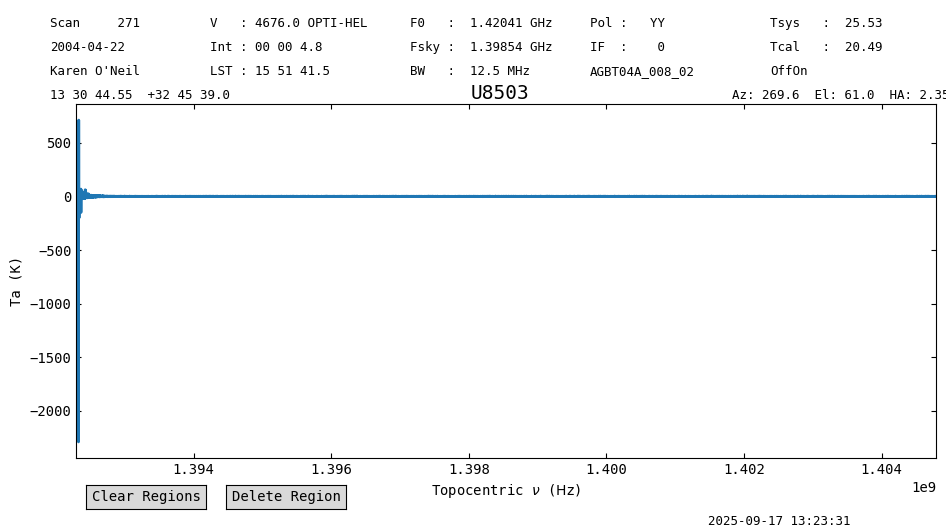

In [21]:
pssb0_int0.plot()

The y-axis can be adjusted during the call to `plot`, through the `ymin` and `ymax` arguments.

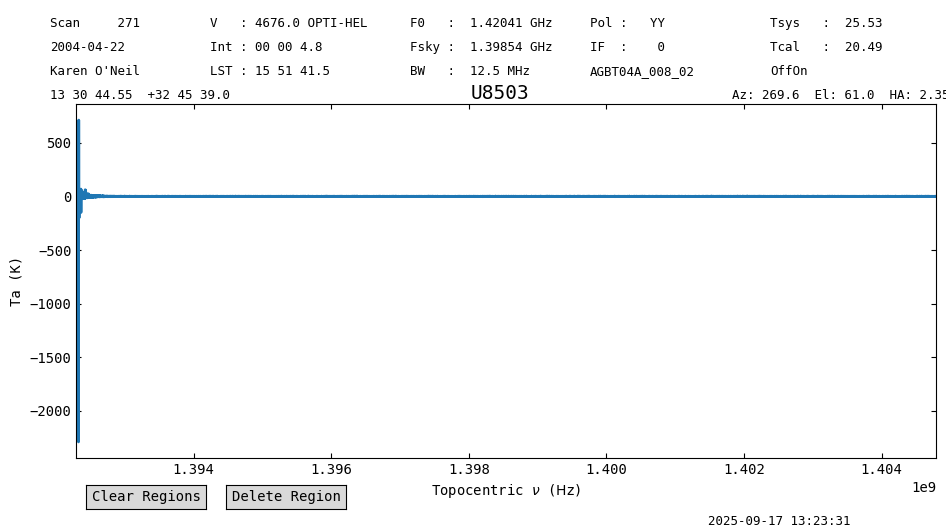

In [22]:
pssb0_int0.plot(ymin=-5, ymax=5)

Since this is a single integration, there's not much to see. Let's work on a time average now.

#### Time Averaging Integrations

Time averaging can be done using the {py:class}`timeaverage <dysh.spectra.scan.ScanBlock.timeaverage>` method of a `Scan` or `ScanBlock`. By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

`timeaverage` will return a `Spectrum` object.

In [23]:
ps0_spec = pssb0.timeaverage()
ps0_spec

<Spectrum(flux=[-19.314772193913075 ... 0.05942943117317884] K (shape=(32768,), mean=0.14476 K); spectral_axis=<SpectralAxis 
   (observer: <ITRS Coordinate (obstime=2004-04-22T07:08:15.000, location=(0., 0., 0.) km): (x, y, z) in m
                  (882593.9465029, -4924896.36541728, 3943748.74743984)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (202.68562135, 32.76085866, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 4676.)>
    observer to target (computed from above):
      radial_velocity=4686.132814909312 km / s
      redshift=0.0157553569969906
    doppler_rest=1420405400.0 Hz
    doppler_convention=optical)
  [1.39229407e+09 1.39229445e+09 1.39229483e+09 ... 1.40479293e+09
 1.40479331e+09 1.40479369e+09] Hz> (length=32768))>

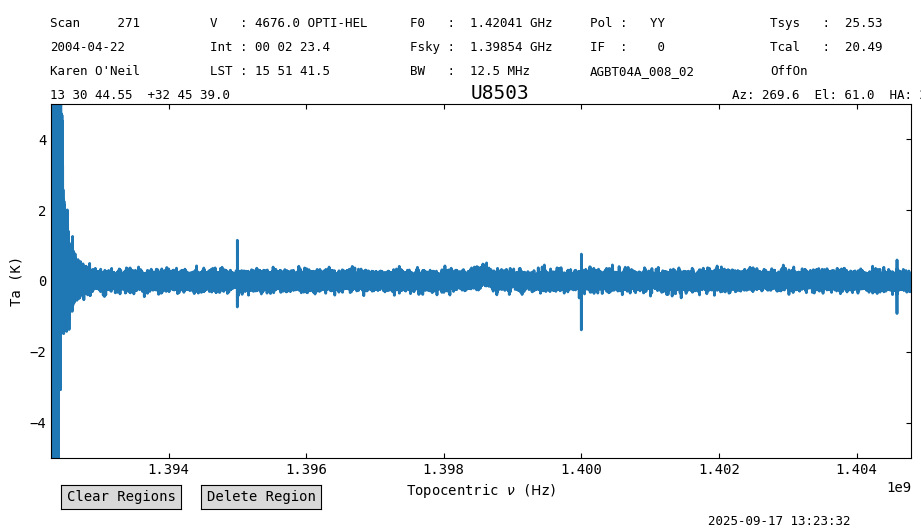

In [24]:
ps0_spec.plot(ymin=-5, ymax=5)

The noise is lower, and there are hints of a signal. Let's smooth the data to further reduce the noise. 

#### Smoothing

Smoothing is done with the {py:class}`smooth <dysh.spectra.spectrum.Spectrum.smooth>` method. By default it decimates the spectrum, so it only retains independent samples. In this case we smooth using a Gaussian kernel with a width of 16 channels.

In [25]:
ps0_spec_smo = ps0_spec.smooth("gauss", 16)

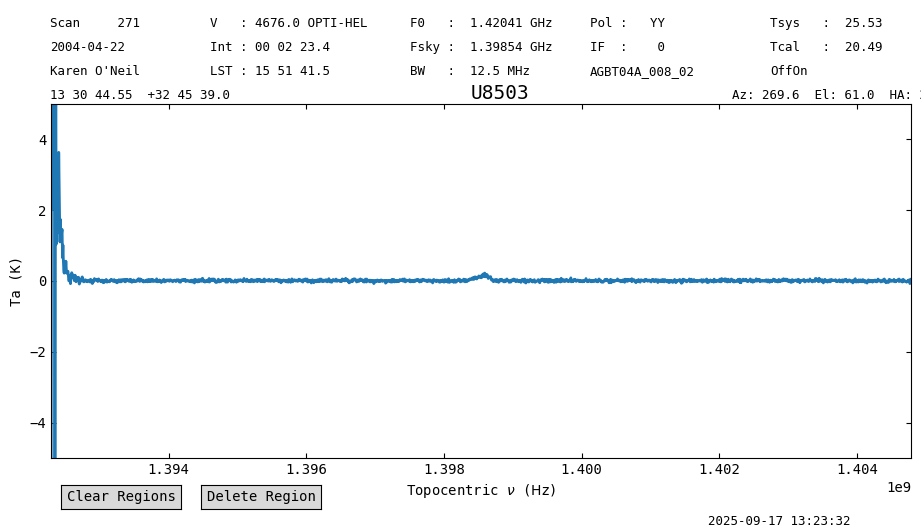

In [26]:
ps0_spec_smo.plot(ymin=-5, ymax=5)

We have to zoom in further to see the signal. We also limit the x-axis range.

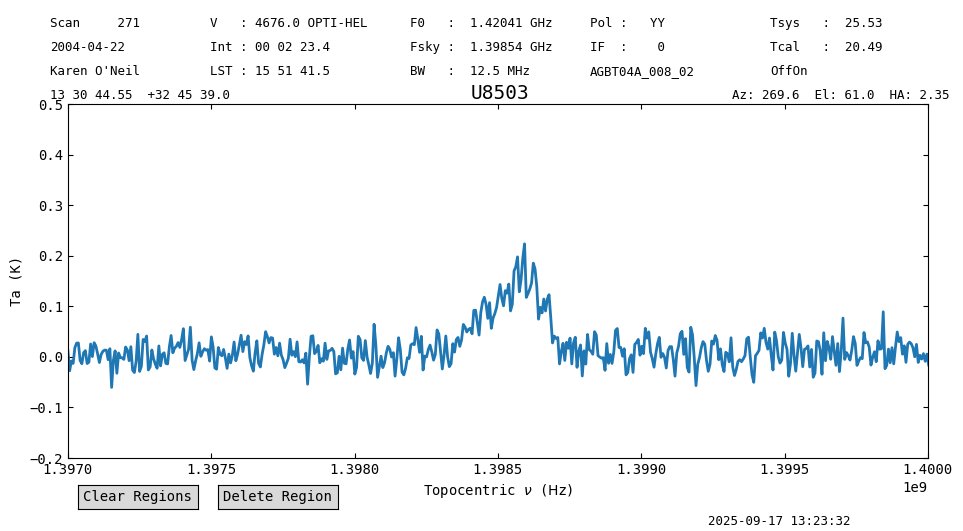

In [27]:
ps0_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

#### Polarization Averaging

While inspecting the data we saw that there are two polarizations. We can average them together to further reduce the noise by a factor $\sqrt{2}$. The second polarization can be calibrated following the above steps, but setting `plnum=1`. Here we also demonstrate the use of chaining to do the data reduction. This refers to using multiple commands in a chain, like

In [28]:
ps1_spec_smo = sdfits.getps(scan=270, plnum=1, ifnum=0, fdnum=0).timeaverage().smooth("gauss", 16)

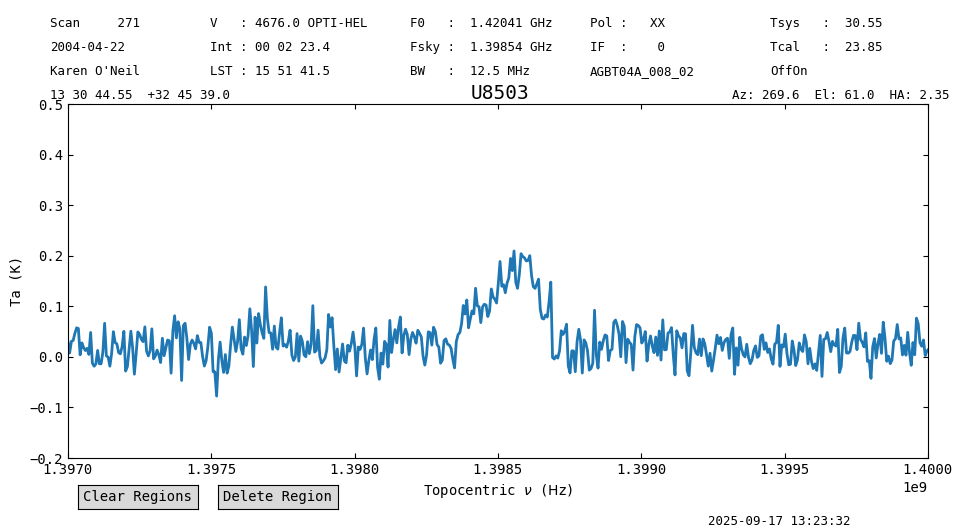

In [29]:
ps1_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

Now we average the smoothed spectra for both polarizations using the {py:class}`average <dysh.spectra.spectrum.Spectrum.average>` method.

In [30]:
ps_spec_smo = ps0_spec_smo.average([ps1_spec_smo])

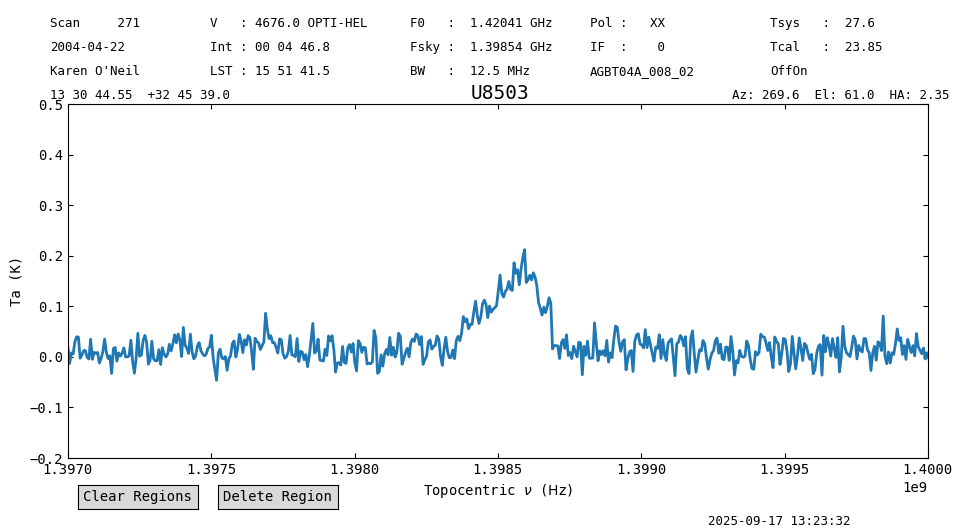

In [31]:
ps_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

#### Statistics

Now we will compare the noise properties of the spectra. For this we leverage the ability to slice spectra. First, we replot the spectra over the whole x-range to find a good frequency range where to compute statistics.

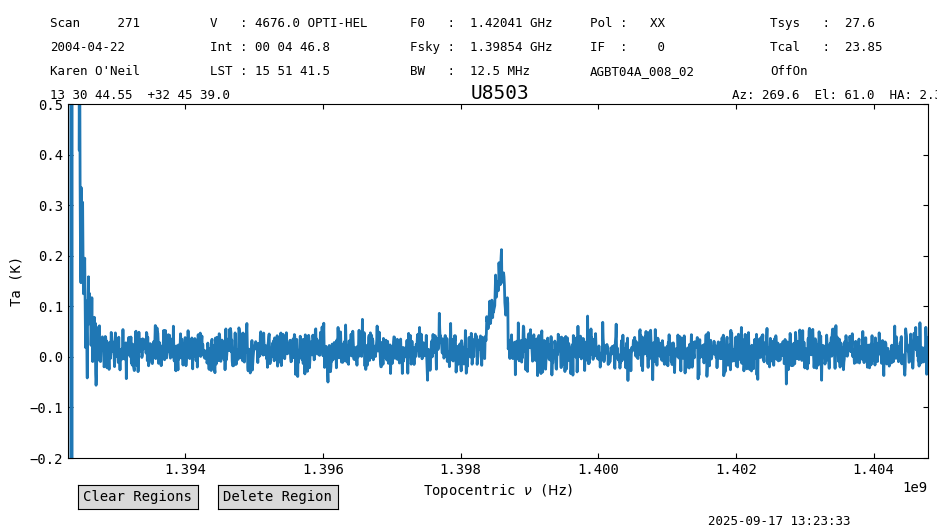

In [32]:
ps_spec_smo.plotter.reset()
ps_spec_smo.plot(ymin=-0.2, ymax=0.5)

We use the range between 1394 MHz and 1398 MHz, and then compute the statistics over this range using the {py:class}`stats <dysh.spectra.spectrum.Spectrum.stats>` method of a `Spectrum`.

In [33]:
s = slice(1394*u.MHz, 1398*u.MHz)
ps_spec_smo[s].stats()

{'mean': <Quantity 0.01366711 K>,
 'median': <Quantity 0.0138482 K>,
 'rms': <Quantity 0.02056197 K>,
 'min': <Quantity -0.04982653 K>,
 'max': <Quantity 0.0861573 K>}

Now for the individual polarizations.

In [34]:
ps0_spec_smo[s].stats(), ps1_spec_smo[s].stats()

({'mean': <Quantity 0.00894887 K>,
  'median': <Quantity 0.00802389 K>,
  'rms': <Quantity 0.0236396 K>,
  'min': <Quantity -0.07328762 K>,
  'max': <Quantity 0.07712214 K>},
 {'mean': <Quantity 0.02042203 K>,
  'median': <Quantity 0.01898732 K>,
  'rms': <Quantity 0.02968233 K>,
  'min': <Quantity -0.07752056 K>,
  'max': <Quantity 0.13824821 K>})

The individual polarizations had an rms of $\approx0.0255$ K, and the average an rms of $0.02$ K. Thus, the average has a noise a factor of $0.9\sqrt{2}$ lower than the individual polarizations. That is $10\%$ higher than expected.

#### Baseline Subtraction

Now we will subtract a baseline from the averaged spectrum. For this we use the {py:class}`baseline <dysh.spectra.spectrum.Spectrum.baseline>` method. It is important to use a range of frequencies that will not bias the baseline fit. We exclude the range at the low-frequency end of the spectral window, up to 1394 MHz, and the range that contains the spectral line, between 1398 and 1400 MHz. In this case we use a polynomial of order 1 as our baseline model.

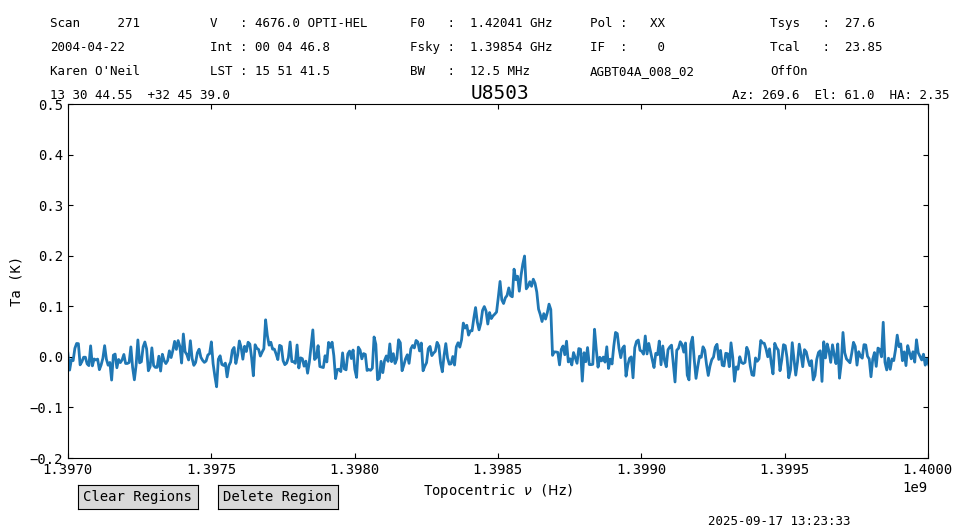

In [35]:
exclude = [(1*u.GHz,1.394*u.GHz),(1.398*u.GHz,1.4*u.GHz)]
ps_spec_smo.baseline(1, model="poly", exclude=exclude, remove=True)
ps_spec_smo.plot(ymin=-0.2, ymax=0.5, xmin=1.397e9, xmax=1.400e9)

In [36]:
ps_spec_smo[s].stats()

{'mean': <Quantity 0.00027589 K>,
 'median': <Quantity 0.00033945 K>,
 'rms': <Quantity 0.02056173 K>,
 'min': <Quantity -0.0631958 K>,
 'max': <Quantity 0.07325353 K>}

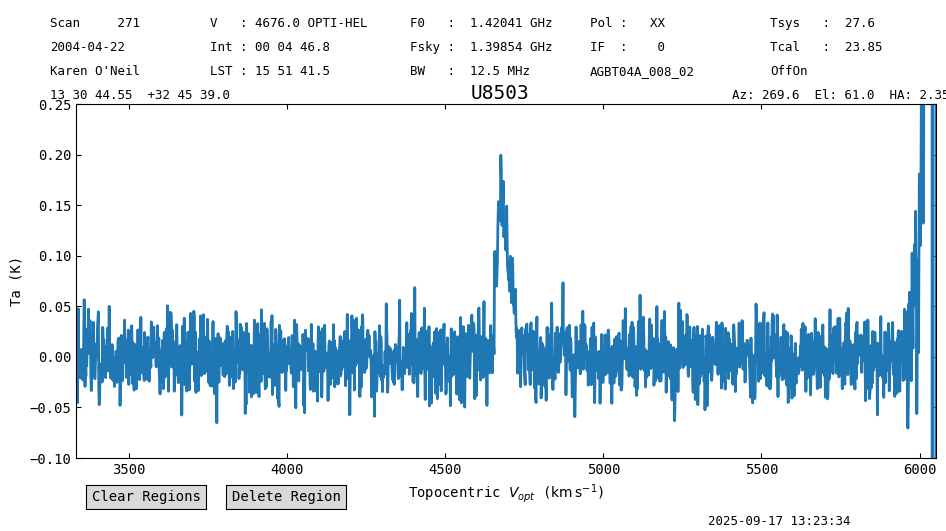

In [37]:
ps_spec_smo.plot(ymax=0.25, ymin=-0.1, xaxis_unit="km/s")

The mean and median are closer to zero now.

### Multiple On/Off Pairs

Now that we understand how to process a single pair of On/Off scans, we proceed to calibrate a bunch of them. In `dysh` this can be accomplished by either, giving a list of scans to the calibration routines, or by selecting the scans based on another property of the data. 

#### Using a List of Scans

First we need to figure out all of the scans for a particular source. For U8503, there is a single pair of On/Off scans, so we need to use a different source. We use 3C286, for which we have scans 220, 221, 222, 223, 224, 225, 226, 227 using OffOn with the noise diodes. 

We could have figured out which scans using:

In [38]:
scan_list = list(set(sdfits["SCAN"][(sdfits["OBJECT"] == "3C286") & \
                     (sdfits["PROC"] == "OffOn") & (sdfits["CAL"] == "T")]))
sorted(scan_list)

[220, 221, 222, 223, 224, 225, 226, 227]

In [39]:
ps0_obj = sdfits.getps(scan=scan_list, plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_obj = sdfits.getps(scan=scan_list, plnum=1, ifnum=0, fdnum=0).timeaverage()
ps_obj = ps0_obj.average(ps1_obj)

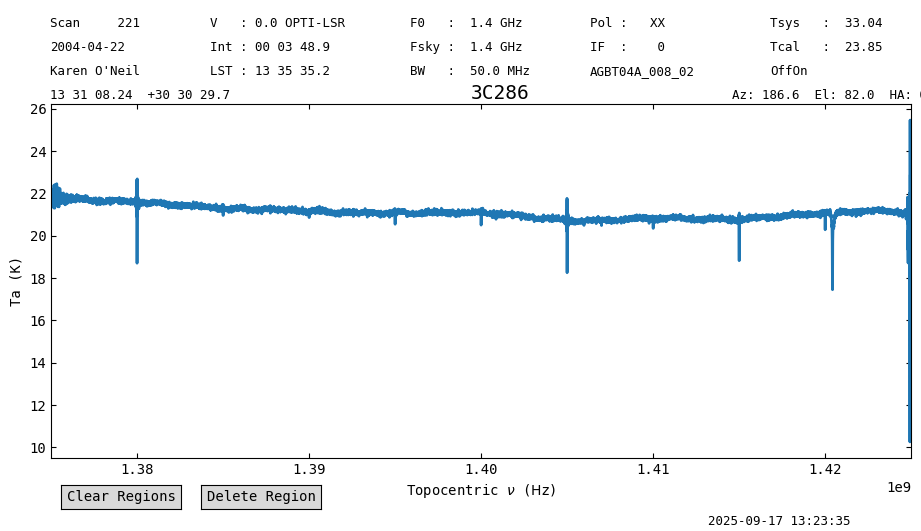

In [40]:
ps_obj.plot()

Since 3C286 is a continuum source, we can see Galactic HI absorption against the continuum.

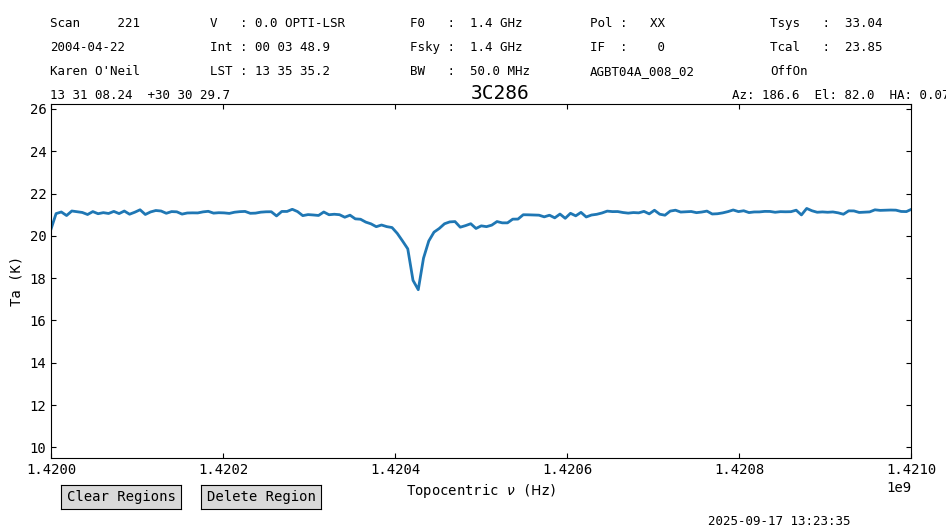

In [41]:
ps_obj.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

#### Using Selection

We can do the same by using the {py:class}`selection <dysh.fits.gbtfitsload.GBTFITSLoad.selection>` method before calling `getps`.

In [42]:
sdfits.select(object="3C286", proc="OffOn")
ps0_obj_b = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_obj_b = sdfits.getps(plnum=1, ifnum=0, fdnum=0).timeaverage()
ps_obj_b = ps0_obj_b.average(ps1_obj_b)

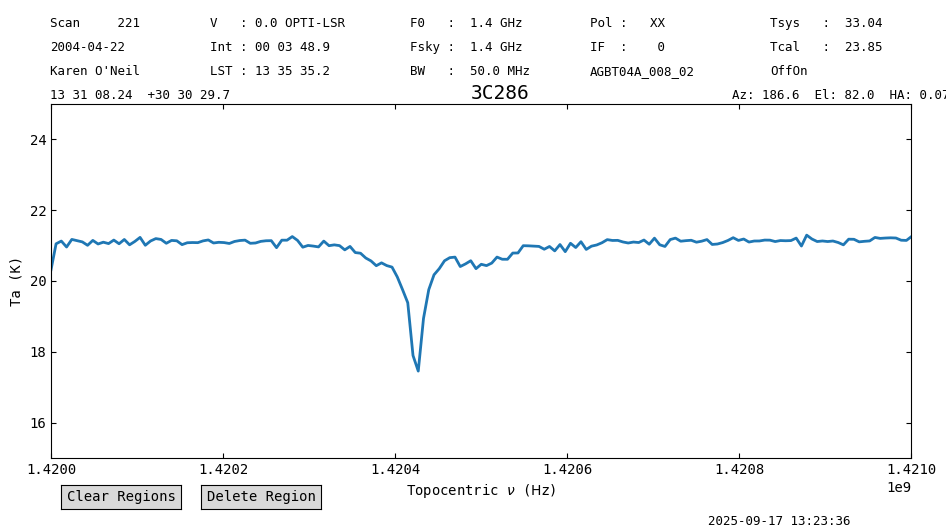

In [43]:
ps_obj_b.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

Once you are done calibrating, you should clear the selection to have access to all the data again.

In [44]:
sdfits.selection.clear()

#### Using Arguments

We can accomplish the same by specifying the `object` and procedure type (`proc`) during the call to `getps`. Any of the calibration methods ({py:class}`getps <dysh.fits.gbtfitsload.GBTFITSLoad.getps>`, {py:class}`getfs <dysh.fits.gbtfitsload.GBTFITSLoad.getfs>`, {py:class}`getnod <dysh.fits.gbtfitsload.GBTFITSLoad.getnod>`, {py:class}`getsigref <dysh.fits.gbtfitsload.GBTFITSLoad.getsigref>`, {py:class}`subbeamnod <dysh.fits.gbtfitsload.GBTFITSLoad.subbeamnod>`, ) can take as argument any of the [columns of an SDFITS file](https://dysh.readthedocs.io/en/latest/reference/sdfits_files/gbt_sdfits.html#data). When used this way, the calibration routine will only use the data that satisfies the conditions, so for example, if we use `sdfits.getps(object="3C286", plnum=0, ifnum=0, fdnum=0)` the calibration routine will only use data that has the column "OBJECT" equal to "3C286".

Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.


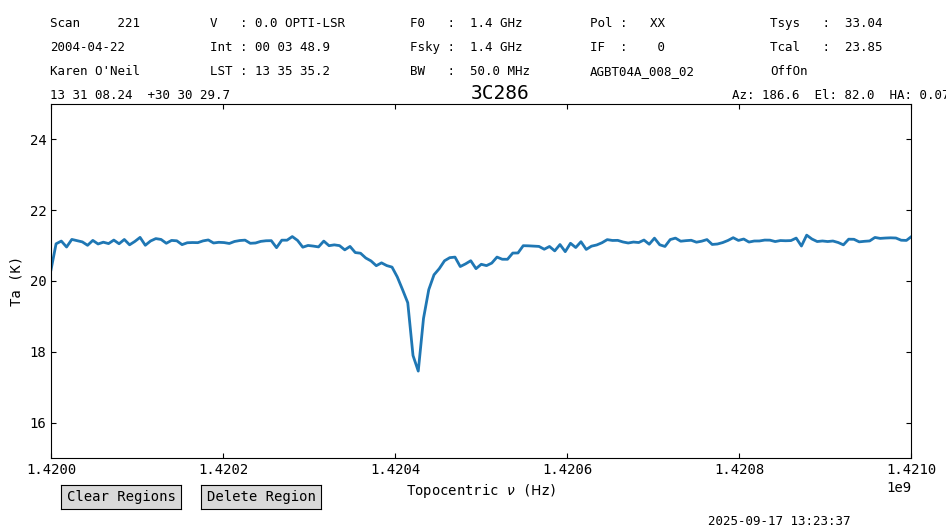

In [45]:
ps0_obj_c = sdfits.getps(plnum=0, ifnum=0, fdnum=0, object="3C286", proc="OffOn").timeaverage()
ps1_obj_c = sdfits.getps(plnum=1, ifnum=0, fdnum=0, object="3C286", proc="OffOn").timeaverage()
ps_obj_c = ps0_obj_c.average(ps1_obj_c)
ps_obj_c.plot(xmin=1.420e9, xmax=1.421e9, ymin=15, ymax=25)

### Calibration Without Noise Diodes

Most of the scans in this example did not use the noise diode. In this case we need to provide a value for the system temperature so that the data can be calibrated. For this particular observation, there is one Track observing procedure associated with the OffOn pairs. For these Track observations, the noise diode was fired, so we can use them to figure out the system temperature.

We will work on observations of U11627. For this source the Track scan is 320, and the OffOn pairs are in scans 316, 317, 318 and 319.

First we use {py:class}`gettp <dysh.fits.gbtfitsload.GBTFITSLoad.gettp>` to figure out the system temperature from the Track scan.

In [46]:
tp0 = sdfits.gettp(scan=320, plnum=0, ifnum=0, fdnum=0).timeaverage()
tp1 = sdfits.gettp(scan=320, plnum=1, ifnum=0, fdnum=0).timeaverage()

The system temperature is stored in the `meta` dictionary of each `Spectrum`.

In [47]:
print(f"System temperature for plnum={tp0.meta['PLNUM']}: {tp0.meta['TSYS']:.2f} K")
print(f"System temperature for plnum={tp1.meta['PLNUM']}: {tp1.meta['TSYS']:.2f} K")

System temperature for plnum=0: 26.33 K
System temperature for plnum=1: 31.30 K


Now we use these values to calibrate the data. The system temperature is provided for the calibration methods through the `t_sys` argument. It is assumed to be in K.

In [48]:
sdfits.select(object="U11627", proc="OffOn")
ps0_wtsys = sdfits.getps(plnum=0, ifnum=0, fdnum=0, t_sys=tp0.meta['TSYS']).timeaverage()
ps1_wtsys = sdfits.getps(plnum=1, ifnum=0, fdnum=0, t_sys=tp1.meta['TSYS']).timeaverage()
ps_wtsys = ps0_wtsys.average(ps1_wtsys)

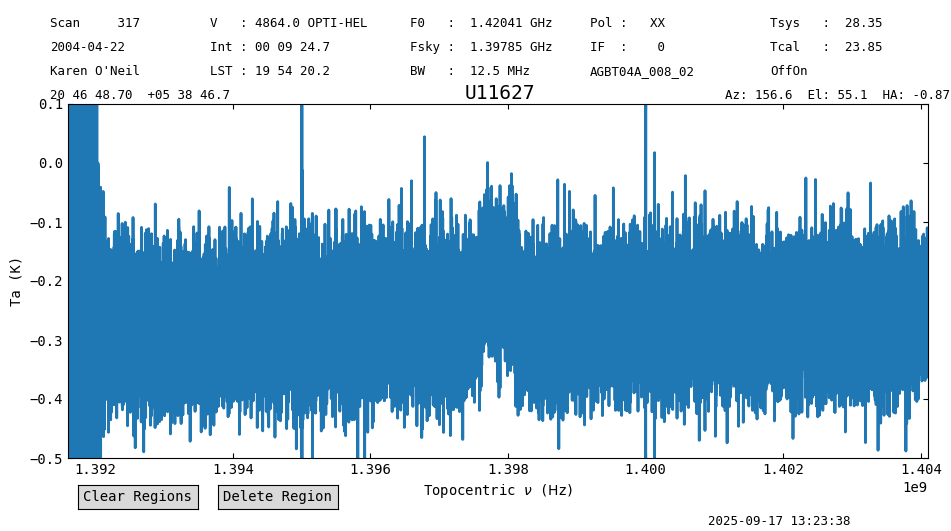

In [49]:
ps_wtsys.plot(ymin=-0.5, ymax=0.1)

Now we smooth and remove a baseline.

In [50]:
ps_wtsys_smo = ps_wtsys.smooth("gauss", 16)
ps_wtsys_smo.baseline(1, model="poly", exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], remove=True)

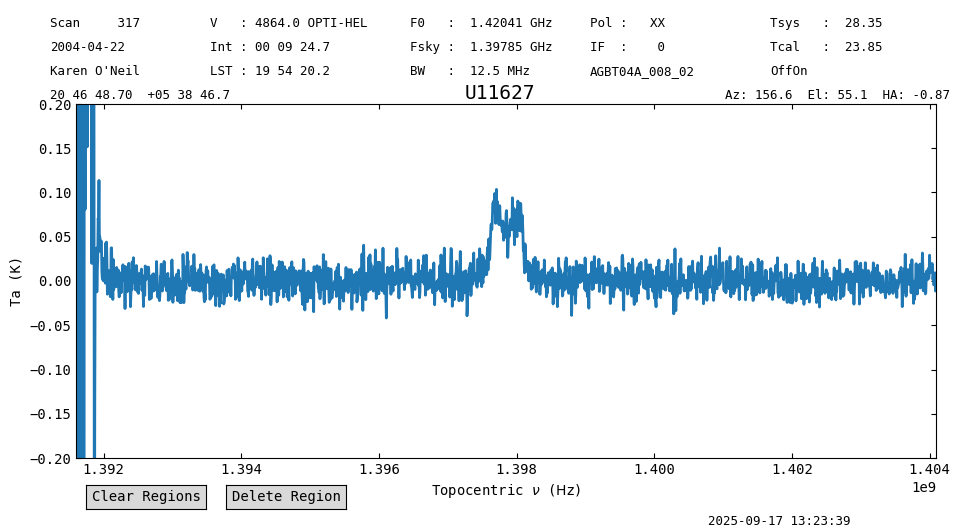

In [51]:
ps_wtsys_smo.plot(ymin=-0.2, ymax=0.2)

In [52]:
sdfits.selection.clear()

### Combining Off Spectra

In some situations we would like to have more flexibility during calibration to specify what will be the Off or reference spectrum used for calibration. In these cases we can use the {py:class}`GBTFITSLoad.getsigref <dysh.fits.gbtfitsload.GBTFITSLoad.getsigref>` function. This function takes as inputs a scan number, or list of them, to be used as On, and a reference spectrum, or scan number (only one in this case). Here we will combine the two Off source spectra from the previous calibration before calibrating the data.

We use {py:class}`gettp <dysh.fits.gbtfitsload.GBTFITSLoad.gettp>` to produce the reference spectrum.

In [53]:
tp_ref0 = sdfits.gettp(scan=[316,318], plnum=0, ifnum=0, fdnum=0, t_sys=tp0.meta['TSYS']).timeaverage()
tp_ref1 = sdfits.gettp(scan=[316,318], plnum=1, ifnum=0, fdnum=0, t_sys=tp1.meta['TSYS']).timeaverage()

Now use `getsigref` to do the calibration. Since we specified the system temperature in the previous call to `gettp`, we do not need to provide it again.

In [54]:
sdfits.select(object="U11627", proc="OffOn")
ps0_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref0, plnum=0, ifnum=0, fdnum=0).timeaverage()
ps1_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref1, plnum=1, ifnum=0, fdnum=0).timeaverage()

Average both polarizations, smooth and remove a baseline like before so we can compare the results.

In [55]:
ps_wtsys_tpr = ps0_wtsys_tpr.average(ps1_wtsys_tpr)
ps_wtsys_tpr_smo = ps_wtsys_tpr.smooth("gauss", 16)
ps_wtsys_tpr_smo.baseline(1, model="poly", 
                          exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], 
                          remove=True)

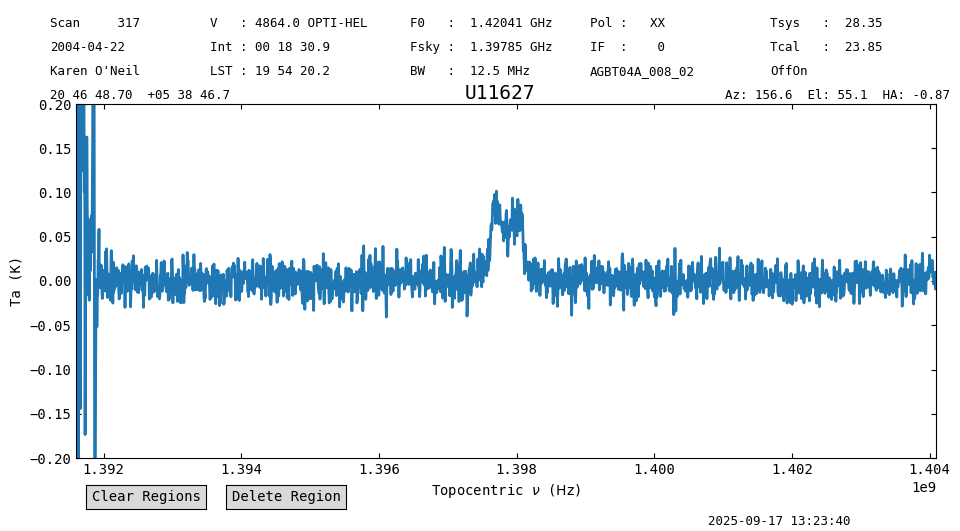

In [56]:
ps_wtsys_tpr_smo.plot(ymin=-0.2, ymax=0.2)

Now compare the noise in the end products.

In [57]:
s = slice(1.393*u.GHz, 1.396*u.GHz)
rms_tpr = ps_wtsys_tpr_smo[s].stats()["rms"]
rms = ps_wtsys_smo[s].stats()["rms"]
print(f"Ratio of rms: {rms_tpr/rms}")

Ratio of rms: 0.9999915456750644


In this case, using a combined reference spectrum improved the noise by an insignificant amount, $\approx0.02\%$.

### Working in Flux Units

So far we have calibrated the data to antenna temperature units, but it is also possible to work on flux units. To do so, we must provide a zenith opacity value and specify that we want the data in Jy, using the `zenith_opacity` and `units` parameters. Since this data is observed at 1.4 GHz, we use a small value for the zenith opacity, 0.08. For more details on how to find the zenith opacity for your observations, please see [this guide](https://gbtdocs.readthedocs.io/en/latest/how-tos/data_reduction/calculate_opacity.html). We also repeat the previous calibration steps.

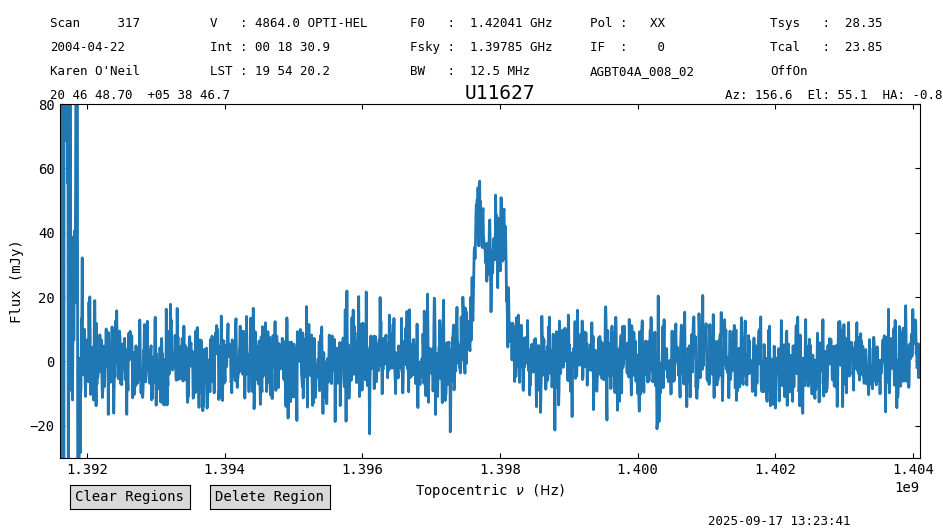

In [58]:
ps0_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref0, plnum=0, ifnum=0, fdnum=0, 
                                 units="flux", zenith_opacity=0.08).timeaverage()
ps1_wtsys_tpr = sdfits.getsigref(scan=[317,319], ref=tp_ref1, plnum=1, ifnum=0, fdnum=0, 
                                 units="flux", zenith_opacity=0.08).timeaverage()
ps_wtsys_tpr = ps0_wtsys_tpr.average(ps1_wtsys_tpr)
ps_wtsys_tpr_smo = ps_wtsys_tpr.smooth("gauss", 16)
ps_wtsys_tpr_smo.baseline(1, model="poly", 
                          exclude=[(1*u.GHz,1.393*u.GHz),(1.397*u.GHz,1.399*u.GHz)], 
                          remove=True)
ps_wtsys_tpr_smo.plot(ymin=-30, ymax=80, yaxis_unit="mJy")

## Measuring Line Properties

`Spectrum` objects provide a convenience function for analysis of HI profiles based on the Curve of Growth (CoG) method by [Yu et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...898..102Y/abstract), through the {py:class}`cog <dysh.spectra.spectrum.Spectrum.cog>` method. The implementation of this method can retrieve line parameters in a fully automated way, however, this is likely to work only in high signal-to-noise cases (>10). In low signal-to-noise cases, additional inputs are required to aid the method. In particular, it helps to provide a good estimate of the central velocity of the line using the `vc` parameter and/or restricting the range over which the method is applied, either by slicing the `Spectrum` or using the `bchan` and `echan` parameters.

First we apply the method blindly, ignoring the edge channels.

In [59]:
line_props = ps_wtsys_tpr_smo[60:-60].cog()
line_props

{'flux': <Quantity 5.07823274 Jy km / s>,
 'flux_std': <Quantity 0.34899029 Jy km / s>,
 'flux_r': <Quantity 0.5966902 Jy km / s>,
 'flux_r_std': <Quantity 0.1900661 Jy km / s>,
 'flux_b': <Quantity 4.40853276 Jy km / s>,
 'flux_b_std': <Quantity 0.23341427 Jy km / s>,
 'width': {0.25: <Quantity 49.23181793 km / s>,
  0.65: <Quantity 155.67900098 km / s>,
  0.75: <Quantity 182.29080043 km / s>,
  0.85: <Quantity 208.90260197 km / s>,
  0.95: <Quantity 246.15912821 km / s>},
 'width_std': {0.25: <Quantity 2.70678139 km / s>,
  0.65: <Quantity 5.54806763 km / s>,
  0.75: <Quantity 6.90214849 km / s>,
  0.85: <Quantity 17.43611058 km / s>,
  0.95: <Quantity 9.64092378 km / s>},
 'A_F': 7.388310972733574,
 'A_C': 3.5630291659202062,
 'C_C': 4.2432437142336825,
 'rms': <Quantity 0.00695291 Jy>,
 'bchan': 738,
 'echan': 1108,
 'vel': <Quantity 4891.75339314 km / s>,
 'vel_std': <Quantity 600.65656517 km / s>}

Plot the results along with the central velocity and the line width that encompasses 95% of the total flux.

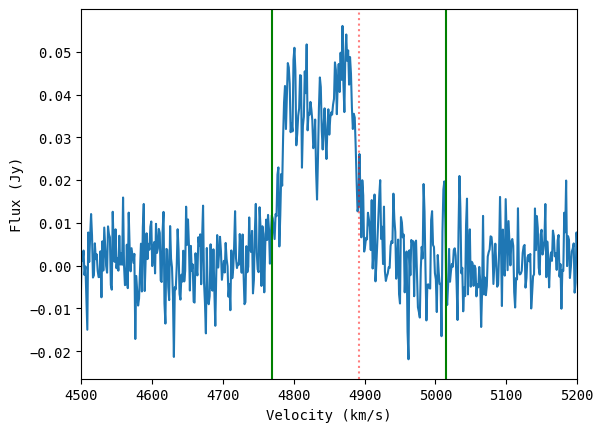

In [60]:
plt.figure()
plt.plot(ps_wtsys_tpr_smo[60:].spectral_axis.to("km/s"), ps_wtsys_tpr_smo[60:].flux)
plt.axvline(line_props["vel"].value, c="r", alpha=0.5, ls=":")
plt.axvline((line_props["vel"] - line_props["width"][0.95]/2).value, c="g")
plt.axvline((line_props["vel"] + line_props["width"][0.95]/2).value, c="g")
plt.xlim(4500, 5200)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (Jy)");

The results are not great. Use CoG again, but providing a range of channels through the `bchan` and `echan` parameters (these can only be channel numbers).

In [61]:
line_props_wrange = ps_wtsys_tpr_smo[60:-60].cog(bchan=line_props["bchan"], echan=line_props["echan"])
line_props_wrange

{'flux': <Quantity 4.72722808 Jy km / s>,
 'flux_std': <Quantity 0.05107974 Jy km / s>,
 'flux_r': <Quantity 2.60136065 Jy km / s>,
 'flux_r_std': <Quantity 0.07606605 Jy km / s>,
 'flux_b': <Quantity 2.12677119 Jy km / s>,
 'flux_b_std': <Quantity 0.06468191 Jy km / s>,
 'width': {0.25: <Quantity 33.25196154 km / s>,
  0.65: <Quantity 81.13478735 km / s>,
  0.75: <Quantity 91.77541565 km / s>,
  0.85: <Quantity 107.73635843 km / s>,
  0.95: <Quantity 158.27934713 km / s>},
 'width_std': {0.25: <Quantity 1.36866178 km / s>,
  0.65: <Quantity 1.55611853 km / s>,
  0.75: <Quantity 1.61419184 km / s>,
  0.85: <Quantity 1.71204216 km / s>,
  0.95: <Quantity 4.29457243 km / s>},
 'A_F': 1.223150222510423,
 'A_C': 1.0622926871036373,
 'C_C': 3.2400000916649785,
 'rms': <Quantity 0.00695291 Jy>,
 'bchan': 738,
 'echan': 1108,
 'vel': <Quantity 4833.02405876 km / s>,
 'vel_std': <Quantity 248.51383112 km / s>}

In [62]:
line_props_wrange = ps_wtsys_tpr_smo[60:-60].cog(bchan=750, echan=1100)
line_props_wrange

{'flux': <Quantity 4.72159151 Jy km / s>,
 'flux_std': <Quantity 0.05255238 Jy km / s>,
 'flux_r': <Quantity 2.54269603 Jy km / s>,
 'flux_r_std': <Quantity 0.07779221 Jy km / s>,
 'flux_b': <Quantity 2.17711324 Jy km / s>,
 'flux_b_std': <Quantity 0.05728901 Jy km / s>,
 'width': {0.25: <Quantity 33.2525423 km / s>,
  0.65: <Quantity 81.1362044 km / s>,
  0.75: <Quantity 91.77701855 km / s>,
  0.85: <Quantity 107.73824009 km / s>,
  0.95: <Quantity 155.62190763 km / s>},
 'width_std': {0.25: <Quantity 1.37118394 km / s>,
  0.65: <Quantity 1.55624457 km / s>,
  0.75: <Quantity 1.61633028 km / s>,
  0.85: <Quantity 1.71207207 km / s>,
  0.95: <Quantity 5.54603245 km / s>},
 'A_F': 1.1679208853012009,
 'A_C': 1.0831599094036801,
 'C_C': 3.2400000916665244,
 'rms': <Quantity 0.00693929 Jy>,
 'bchan': 750,
 'echan': 1100,
 'vel': <Quantity 4835.71843257 km / s>,
 'vel_std': <Quantity 244.60438983 km / s>}

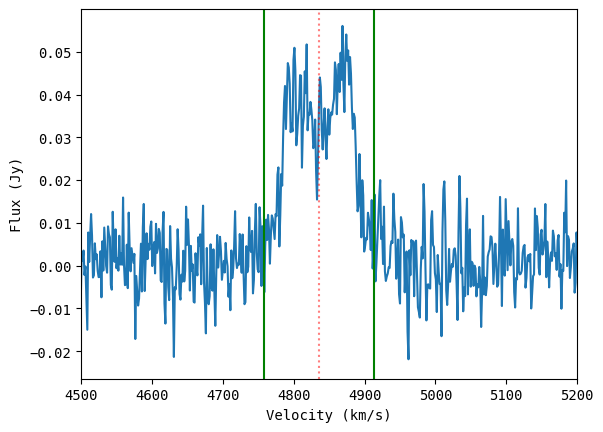

In [63]:
plt.figure()
plt.plot(ps_wtsys_tpr_smo[60:].spectral_axis.to("km/s"), ps_wtsys_tpr_smo[60:].flux)
plt.axvline(line_props_wrange["vel"].value, c="r", alpha=0.5, ls=":")
plt.axvline((line_props_wrange["vel"] - line_props_wrange["width"][0.95]/2).value, c="g")
plt.axvline((line_props_wrange["vel"] + line_props_wrange["width"][0.95]/2).value, c="g")
plt.xlim(4500, 5200)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (Jy)");

Much better!

## Putting it all Together

Now we can use what we have learned to process all of the observations.
We will loop over all the objects, calibrating the data.
For the system temperature, we use the last Track observation associated with a given object.
Since there may have been issues with the previous Track observations if they had to be repeated (for example, for U11578 the first Track observation did not fire the noise diode).
We process "U8503" individually, because there is no "Track" scan for it but the OffOn observations did use the noise diode.

We put all the steps in a function, `process`. This makes it easier to reuse the code, and modify it.

In [64]:
def process(sdfits, object, results, track=True):
    """
    Function to calibrate the AGBT04A_008_02 observations.
    This function was heavily tailored to work with this
    observations and there is no guarantee it would work with
    other data.
    """
    
    o = object

    if track:
        # Use only the last Track observation for every object.
        tp0 = sdfits.gettp(ifnum=0, plnum=0, fdnum=0, object=o, proc="Track")[-1].timeaverage()
        tp1 = sdfits.gettp(ifnum=0, plnum=1, fdnum=0, object=o, proc="Track")[-1].timeaverage()
    
        # Calibrate using the system temperature of the Track scan.
        ps0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, object=o, proc="OffOn", 
                           t_sys=tp0.meta["TSYS"], units="flux", zenith_opacity=0.08).timeaverage()
        ps1 = sdfits.getps(ifnum=0, plnum=1, fdnum=0, object=o, proc="OffOn", 
                           t_sys=tp1.meta["TSYS"], units="flux", zenith_opacity=0.08).timeaverage()

    else:
        # Calibrate computing the system temperature from the Off scan.
        ps0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0, object=o, proc="OffOn", 
                           units="flux", zenith_opacity=0.08).timeaverage()
        ps1 = sdfits.getps(ifnum=0, plnum=1, fdnum=0, object=o, proc="OffOn", 
                           units="flux", zenith_opacity=0.08).timeaverage()

    # Average polarizations.
    ps = ps0.average(ps1)

    # Smooth.
    ps_smo = ps.smooth("gauss", 16)

    # Determine if the Galactic HI line is present, and if so,
    # ignore it during the baseline fit.
    idx0 = np.argmin(abs(ps_smo.spectral_axis - 1.420*u.GHz))
    idxf = np.argmin(abs(ps_smo.spectral_axis - 1.421*u.GHz))
    idx0,idxf = np.sort([idx0,idxf])
    if idx0 == 0 or idx0 == len(ps_smo.data) - 1 or idxf == 0 or idxf == len(ps_smo.data) - 1:
        exclude=[(0,100),(500,1250),(2047-100,2047)]
    else:
        exclude=[(0,100),(500,1250),(idx0,idxf),(2047-100,2047)]

    # Baseline subtraction.
    ps_smo.baseline(degree=1, model="poly", exclude=exclude, remove=True)

    # Measure line properties using Curve of Growth.
    # Ignore 100 channels in each edge, and compute the
    # CoG over the inner (750,1250) channels.
    cog = ps_smo[100:-100].cog(bchan=750, echan=1250, width_frac=[0.95])

    # Save the measured line properties.
    # In particular, the object name, flux and its width.
    results["name"].append(o.replace("U", "UGC "))
    for k in ["flux", "flux_error"]:
        results[k].append(cog[k.replace("error", "std")].to("Jy km/s").value)
    for k in ["width", "width_error"]:
        results[k].append(cog[k.replace("error", "std")][0.95].to("km/s").value)

measured = {"name": [],
            "flux": [],
            "flux_error": [],
            "width": [],
            "width_error": [],
           }

sdfits.selection.clear()
# Start at object 4 since the previous ones were calibration observations.
for o in sdfits.udata("OBJECT")[4:]:

    if o ==  "U8503":
        track = False
    else:
        track = True
    
    process(sdfits, o, measured, track=track)


Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON scan. Will not calibrate.
Scan 266 has no matching ON 

### Compare with the Literature

We can compare the results obtained here with those listed by the author in [this page](https://greenbankobservatory.org/~koneil/HIsurvey/results_all.html). The results are also provided as a text table. We download this table and parse its contents. We save the flux and $W_{20}$ (the width of the line at 20% of the peak flux) values.

In [65]:
table_file = from_url("https://greenbankobservatory.org/~koneil/HIsurvey/results_all.dat", savepath)

In [66]:
data = {"name": [],
        "flux": [],
        "flux_error": [],
        "width": [],
        "width_error": []
       }

# Open the file.
with open(table_file) as f:
    lines = f.readlines()
    # Loop over lines extracting the data we are interested in.
    # The column numbers are provided in the header of the text file.
    for line in lines:
        if line.lstrip().startswith("\\"):
            continue
        data["name"].append(" ".join(line[1:14].strip().split()))
        try:
            data["flux"].append(float(line[49:53].strip()))
        except ValueError:
            data["flux"].append(np.nan)
        data["flux_error"].append(float(line[54:57].strip()))
        try:
            data["width"].append(float(line[58:61].strip()))
        except ValueError:
            data["width"].append(np.nan)
        data["width_error"].append(float(line[62:64].strip()))

Now create `pandas.DataFrame` objects to manipulate the measured and literature results. We use `DataFrame` as it provides a convenient way of handling the data. While loading the data, we sort it by "name". We will also remove sources that do not appear in both data sets.

In [67]:
# Convert to DataFrame and sort.
df_obs = pd.DataFrame.from_dict(measured).sort_values(by="name")
df_lit = pd.DataFrame.from_dict(data).sort_values(by="name")

# Find sources present in both data sets.
shared_names = set(df_obs["name"]) & set(df_lit["name"])

# Keep only the sources found above.
df_obs_s = df_obs[df_obs["name"].isin(shared_names)]
df_lit_s = df_lit[df_lit["name"].isin(shared_names)]

For example, for object 11627 the flux is $2.3\pm0.0$ Jy km s$^{-1}$.

In [68]:
# With Pandas.
print(df_lit_s.loc[df_lit_s["name"] == "UGC 11627"])

print("\n") # Blank line.

# Without Pandas.
idx = data["name"].index("UGC 11627")
print(f"Flux for UGC 11627: {data['flux'][idx]} +- {data['flux_error'][idx]} Jy km/s")

         name  flux  flux_error  width  width_error
94  UGC 11627   2.3         0.0  126.0          9.0


Flux for UGC 11627: 2.3 +- 0.0 Jy km/s


Now that we have the results, plot them.

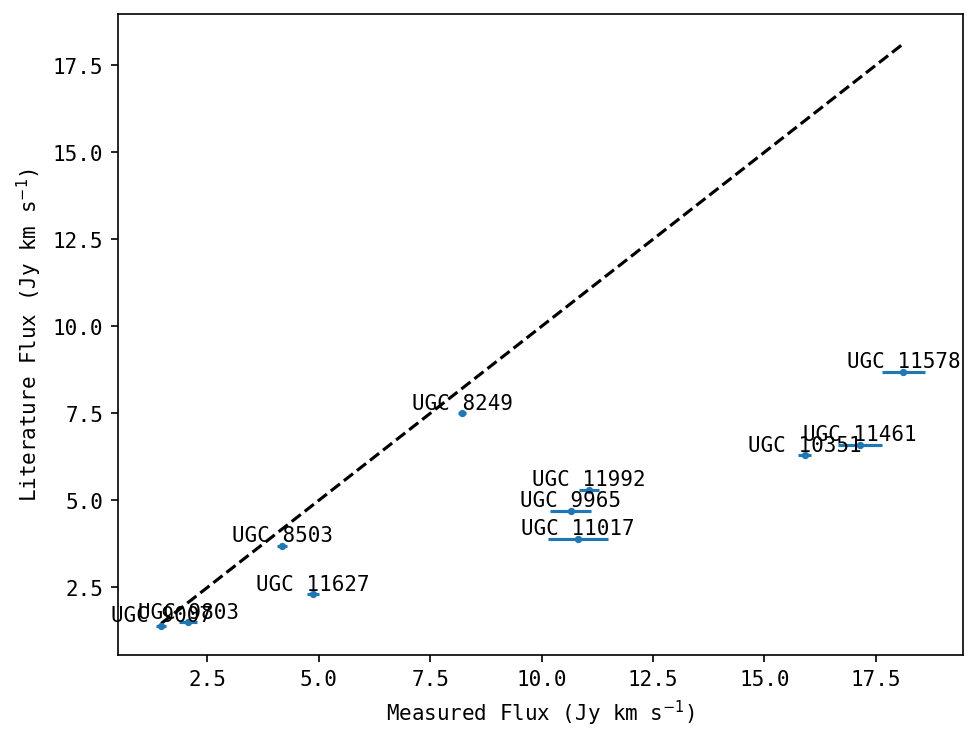

In [69]:
plt.figure(dpi=150)
# Plot a 1-to-1 line using the observed values.
plt.plot(sorted(df_obs_s["flux"]), sorted(df_obs_s["flux"]), "k--")
plt.errorbar(df_obs_s["flux"], df_lit_s["flux"], 
             xerr=df_obs_s["flux_error"], 
             yerr=df_lit_s["flux_error"], 
             marker=".", ls="", ms=5)
for n,o,l in zip(df_obs_s["name"], df_obs_s["flux"], df_lit_s["flux"]):
    plt.text(o, l, n, ha="center", va="bottom")
plt.tight_layout()
plt.xlabel("Measured Flux (Jy km s$^{-1}$)")
plt.ylabel("Literature Flux (Jy km s$^{-1}$)");

There are significant differences between the tabulated values and those measured from this data set.
At the time of writing we do not understand the origin of the difference. As far as we can tell, processing the data in GBTIDL produces equivalent results as those presented here (the differences in flux measurements are <1 Jy km s$^{-1}$). Stay tuned for an update.

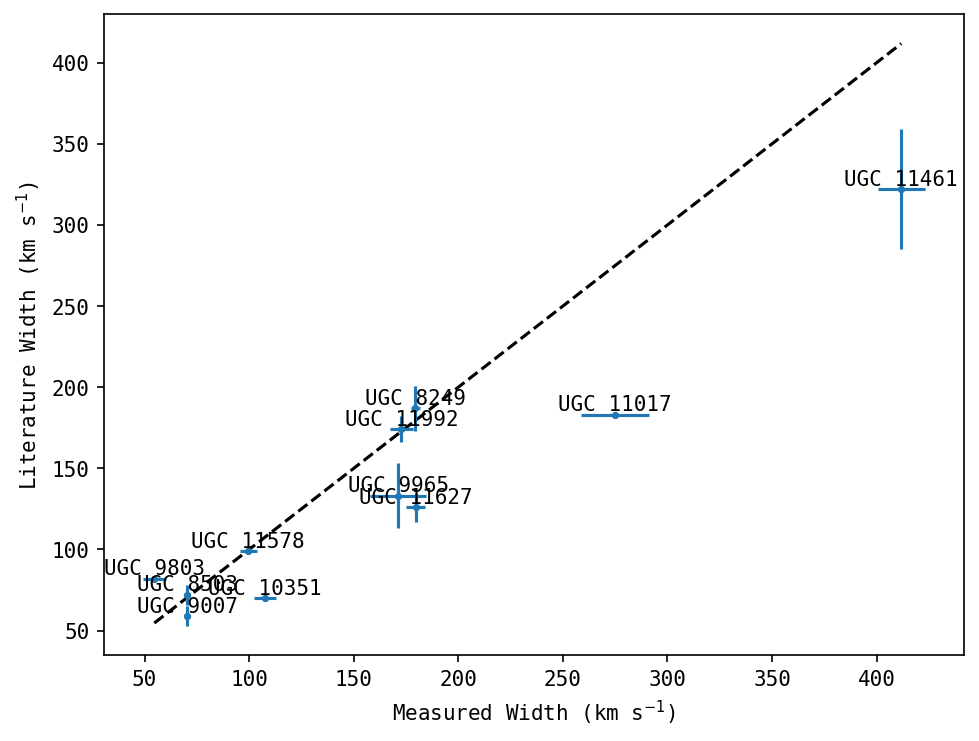

In [70]:
plt.figure(dpi=150)
# Plot a 1-to-1 line using the observed values.
plt.plot(sorted(df_obs_s["width"]), sorted(df_obs_s["width"]), "k--")
plt.errorbar(df_obs_s["width"], df_lit_s["width"], 
             xerr=df_obs_s["width_error"], 
             yerr=df_lit_s["width_error"], 
             marker=".", ls="", ms=5)
for n,o,l in zip(df_obs_s["name"], df_obs_s["width"], df_lit_s["width"]):
    plt.text(o, l, n, ha="center", va="bottom")
plt.tight_layout()
plt.xlabel("Measured Width (km s$^{-1}$)")
plt.ylabel("Literature Width (km s$^{-1}$)");

The widths agree much better, since they do not depend on the flux calibration.